In [1]:
from pandas import Timedelta, to_datetime
from matplotlib.pyplot import subplots, savefig, show, legend, close
from pandas import read_csv, read_parquet
from glob import glob
from collections import defaultdict
from pandas import Series
from tqdm import tqdm
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter
from random import choice as choose_randomly
from pandas import Timestamp
from pandas.core.indexes.base import Index
from tqdm.notebook import tqdm
from pandas import DataFrame, IndexSlice
from gc import collect as garbage_collect

subset_data: bool = False


def make_biometrics_plots_together_matplotlib(
    data: defaultdict[str, defaultdict[str, defaultdict[str, Series]]],
    user_id: str,
    session_id: str,
    dataset: str,
    experiment_info: DataFrame,
    **kwargs,
) -> None:
    data = {key: val for key, val in data.items() if val is not None}
    fig, axs = subplots(
        len(data.keys()), 1, figsize=(14, 11 * len(data.keys())), sharex=True
    )
    if len(data.keys()) == 1:
        axs = [axs]
    
    for n, (data_type, physiological_data) in tqdm(
        enumerate(data.items()), desc="Plotting data", total=len(data.keys())
    ):
        if physiological_data is None:
            continue

        for side, specific_side_data in physiological_data.items():
            user_data: DataFrame = specific_side_data[user_id]

            if data_type == "EDA":
                eda_type: str = kwargs["eda_type"]
                data_to_plot = user_data[eda_type]
            else:
                data_to_plot = user_data.iloc[:, 0]

            data_to_plot = data_to_plot.loc[IndexSlice[session_id, :]]
            if subset_data:
                data_to_plot = data_to_plot[:1000]

            data_to_plot.index = to_datetime(data_to_plot.index)
            axs[n].plot(
                data_to_plot.index,
                data_to_plot.values,
                label=side,
                linestyle="-",
            )
            axs[n].set_title(data_type)

            # del data_to_plot
            # garbage_collect()

        # session_id_corrected: Timestamp = to_datetime(
        #     session_ids["left"].split("-")[0], format="%y%m%d"
        # )  + Timedelta("1D")
        # session_id_corrected: str = str(session_id_corrected.date())
        if dataset == "mwc2022":
            start_exp = Timestamp(
                experiment_info.loc[IndexSlice[user_id, session_id], "actual_bed_time"]
            )
            end_exp = Timestamp(
                experiment_info.loc[IndexSlice[user_id, session_id], "wake_up_time"]
            )
            # start_exp = start_exp.tz_localize("Europe/Rome")
            # end_exp = end_exp.tz_localize("Europe/Rome")

            axs[n].axvspan(
                xmin=start_exp,
                xmax=end_exp,
                color="#828282",
                alpha=0.3,
                label="sleep time",
            )
            axs[n].set_ylabel(f"Time")
            axs[n].set_ylabel(f"{data_type}")
        elif dataset == "usi_laughs":
            events = set(
                ["_".join(col.split("_")[1:]) for col in experiment_info.columns]
            )
            for i, event in enumerate(events):
                start_exp = Timestamp(experiment_info.loc[user_id, f"start_{event}"])
                end_exp = Timestamp(experiment_info.loc[user_id, f"end_{event}"])
                if "baseline" in event and i == 0:
                    label = "baseline"
                elif "baseline" not in event:
                    label = event
                else:
                    label = None

                axs[n].axvspan(
                    xmin=start_exp,
                    xmax=end_exp,
                    color="#828282" if "baseline" in event else "#548572",
                    alpha=0.3,
                    label=label,
                )
                axs[n].set_ylabel(f"Time")
                axs[n].set_ylabel(f"{data_type}")
        else:
            raise ValueError(
                f"Received as dataset {dataset}, but only mwc2022 and usi_laughs are supported"
            )

    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        fontsize="x-large",
        title="Side",
        title_fontsize="xx-large",
        #    loc='best'
    )
    # legend()
    fig.suptitle(
        f"Plots for all singals for user {user_id}, session {session_id}",
        fontsize=30,
        y=0.97,
    )
    savefig(f"../visualizations/{dataset}_{user_id}_{session_id}.pdf")
    # show()
    close()

    return start_exp, end_exp


# Intro

This notebook is intended to provide data exploration for all datasets concerning this Lateralization study. As the moment, the datasets impemented are:
* USILaughs
* MWC2022 study

I split the same notebook into 2, since I was having problems w/ remote working, due too large filesizes.

# USILaughs

The artefacts scripts have been moved inside the EDA filtering.

## Cognitive Load Info

In [2]:
from pandas import read_csv, to_datetime
from pandas import IndexSlice, DataFrame
import pandas as pd

pd.options.display.precision = 5

In [3]:
def move_event_to_columns(df):
    starts = {}
    ends = {}
    for event in df.index.get_level_values(1).unique():
        starts[f"start_{event}"] = df.loc[IndexSlice[:, event], "start"].values
        ends[f"end_{event}"] = df.loc[IndexSlice[:, event], "end"].values
    return DataFrame({**starts, **ends})


experiment_info = read_csv(
    "../data.nosync/usilaughs/all_experimento_info.csv", index_col=[0, 1]
)
indexes_to_drop = [
    idx
    for idx in experiment_info.index
    if "baseline" not in idx[1] and "cognitive_load" not in idx[1]
]
experiment_info = experiment_info.drop(indexes_to_drop, inplace=False)
experiment_info = experiment_info.groupby(axis=0, level=0, group_keys=True).apply(
    move_event_to_columns
)
experiment_info.index = experiment_info.index.droplevel(1)


In [4]:
experiment_info = experiment_info.applymap(to_datetime)
experiment_info = experiment_info.applymap(lambda x: x.tz_localize('Europe/Rome'))

## Physiological Data

In [5]:
from pandas import read_csv, read_parquet
from glob import glob
from collections import defaultdict
from pandas import Series
from tqdm import tqdm
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter
from random import choice as choose_randomly
from pandas import Timestamp
from pandas.core.indexes.base import Index
from tqdm.notebook import tqdm
from pandas import DataFrame, IndexSlice
from gc import collect as garbage_collect

eda_data_base_path: str = "../data.nosync/usilaughs/filtered/*/EDA/*.parquet"
eda_data_paths: list[str] = glob(eda_data_base_path)
eda_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
    lambda: defaultdict()
)
for file in tqdm(eda_data_paths, desc="Loading EDA data"):
    side_name = file.split("/")[-3]
    user_name = file.split("/")[-1].split(".")[0]
    eda_data[side_name][user_name] = read_parquet(file)

bvp_data = None

# bvp_data_base_path: str = "../data/filtered/*/BVP/*.parquet"
# bvp_data_paths: list[str] = glob(bvp_data_base_path)
# bvp_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
#     lambda: defaultdict()
# )
# for file in tqdm(bvp_data_paths, desc="Loading BVP data"):
#     side_name = file.split("/")[-3]
#     user_name = file.split("/")[-1].split(".")[0]
#     bvp_data[side_name][user_name] = read_parquet(file)
    
    
physiological_data: dict[str, defaultdict[str, defaultdict[str, Series]]] = {
    "EDA": eda_data,
    "BVP": bvp_data,
}
del eda_data
del bvp_data
garbage_collect()

Loading EDA data:   0%|          | 0/67 [00:00<?, ?it/s]

252

After inspection, user 40 has to be removed, since his experiment time and the timestamps from the E4 do not match.

In [6]:
experiment_info = experiment_info.drop('s040', axis=0, inplace=False)
del physiological_data['EDA']['left']['s040']
del physiological_data['EDA']['right']['s040']
# del physiological_data['BVP']['left']['s040']
# del physiological_data['BVP']['right']['s040']

In [7]:
users_left = physiological_data["EDA"]["left"].keys()
users_right = physiological_data["EDA"]["right"].keys()
users = list(set(users_left) & set(users_right))
sessions_all = ['experiment']

In [ ]:
# session = session_selection.value
for user in tqdm(sorted(users), desc='Plotting user data', colour='red'):
    for session in sessions_all:
        make_biometrics_plots_together_matplotlib(
            data=physiological_data,
            user_id=user,
            session_id=session,
            dataset='usi_laughs',
            experiment_info=experiment_info,
            eda_type="mixed-EDA",
        )


Plotting user data:   0%|          | 0/32 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
users_in_left_side = set(physiological_data['EDA']['left'].keys())
users_in_right_side = set(physiological_data['EDA']['right'].keys())

In [9]:
print(f"Number of users with both left and right hand data: {len(users_in_left_side & users_in_right_side)}")

Number of users with both left and right hand data: 32


## Segmentation

In this case, I shall perform the segmentation using the raw data. As such, the feature extraction will be 

In [28]:
experiment_info_as_dict: dict[str, Series] = {
    participant: experiment_info.loc[participant, :]
    for participant in list(experiment_info.index.unique())
}

In [29]:
segment_size_in_secs = 4
eda_sample_rate = 4
segment_size_in_sampling_rate: int = segment_size_in_secs * eda_sample_rate

In [30]:
eda_data = physiological_data['EDA']

In [31]:
# user = "U13"
# info = experiment_info_as_dict[user]
# data = eda_data['left'][user]

In [32]:
from numpy import nan, ndarray
from pandas import Timedelta


def get_session_moment(start: Timestamp, end: Timestamp, info: Series) -> int | float:
    # TODO: check that this is working as expected
    # this method gives 0 if the person is awake and 1 if the person is
    if (end < info["end_baseline_1"]) or (
        (start < info["end_baseline_1"] and end > info["end_baseline_1"])
    ):
        return 0
    elif (start > info["end_baseline_1"] and end < info["start_cognitive_load"]) or (
        start > info["end_cognitive_load"]) or (
            start < info["start_cognitive_load"] and end > info["start_cognitive_load"]
        ):
        return nan
    else:
        return 1


data_segmented_left: list[tuple] = []
data_segmented_right: list[tuple] = []
users = list(set(eda_data["left"].keys()) & set(eda_data["right"].keys()))

for user in tqdm(users, desc='User progress', colour='blue'):
    data_left = eda_data["left"][user]
    data_right = eda_data["right"][user]
    info = experiment_info_as_dict[user]
    
    # FIXME: using sessions like this seems stupid, but allows to reuse code
    # from the other experiment. I should however find a way around it
    sessions_all = ['experiment']
    for session in sessions_all:
        session_data_left: DataFrame = data_left.loc[IndexSlice[session, :], :]
        session_data_right: DataFrame = data_right.loc[IndexSlice[session, :], :]

        session_info = info

        starts_left = session_data_left[
            ::segment_size_in_sampling_rate
        ].index.get_level_values(1)
        starts_right = session_data_right[
            ::segment_size_in_sampling_rate
        ].index.get_level_values(1)

        ends_left = (
            session_data_left[::segment_size_in_sampling_rate].index.get_level_values(1)
            + Timedelta(f"{segment_size_in_secs}s")
            - Timedelta(f"{1/eda_sample_rate}s")
        )
        ends_right = (
            session_data_right[::segment_size_in_sampling_rate].index.get_level_values(
                1
            )
            + Timedelta(f"{segment_size_in_secs}s")
            - Timedelta(f"{1/eda_sample_rate}s")
        )

        segments_left = [
            (
                session_data_left.loc[
                    IndexSlice[session, start:end],
                    "mixed-EDA",
                ].values,
                get_session_moment(start, end, session_info),
                user,
                session_data_left.loc[
                    IndexSlice[session, start:end],
                    "Artifact",
                ].values
            )
            for start, end in zip(starts_left, ends_left)
        ]
        segments_right = [
            (
                session_data_right.loc[
                    IndexSlice[session, start:end],
                    "mixed-EDA",
                ].values,
                get_session_moment(start, end, session_info),
                user,
                session_data_left.loc[
                    IndexSlice[session, start:end],
                    "Artifact",
                ].values
            )
            for start, end in zip(starts_right, ends_right)
        ]
        data_segmented_left.append(segments_left)
        data_segmented_right.append(segments_right)


User progress:   0%|          | 0/32 [00:00<?, ?it/s]

In [33]:
from numpy import isnan
values_left = [
    val[0]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]
values_right = [
    val[0]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

labels_left = [
    val[1]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]
labels_right = [
    val[1]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

groups_left = [
    val[2]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]

groups_right = [
    val[2]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

artefacts_left = [
    val[3]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]

artefacts_right = [
    val[3]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]


0    480
1    384
dtype: int64
0    55.55556
1    44.44444
dtype: float64


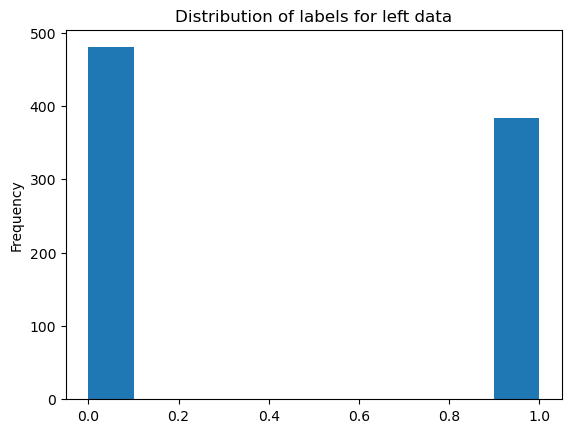

In [35]:
import matplotlib.pyplot as plt

Series(labels_left).plot(kind="hist")
plt.title('Distribution of labels for left data')
print(Series(labels_left).value_counts())
print(Series(labels_left).value_counts()/Series(labels_left).count()*100)

0    480
1    384
dtype: int64
0    55.55556
1    44.44444
dtype: float64


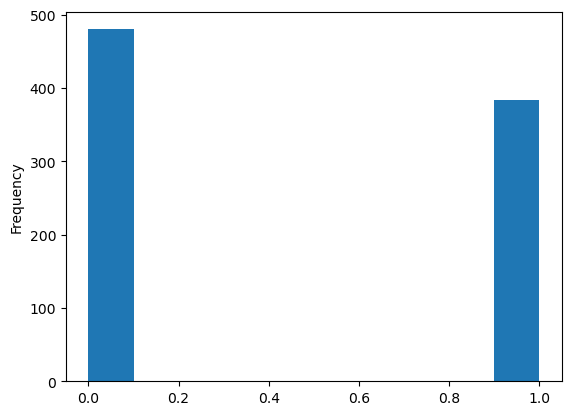

In [36]:
Series(labels_right).plot(kind="hist")
print(Series(labels_right).value_counts())
print(Series(labels_right).value_counts()/Series(labels_right).count()*100)

The distribution is almost balanced: as such, re-balancing should not be a large problem.

## Artefact Removal

In the previous notebook, the training of the model was done without regard for possible artefacts, present in the data. However, it is quite easy to have artefact in EDA data. As such, to methods shall be proposed here for artefact removal.

1. Using Shkurta's method (see https://github.com/shkurtagashi/EDArtifact)
2. Using a simple acc-based logic. The threshold will be decided upon visual inspection and looking at similar literature.

Both methods have been implemented inside the EDA filtering scripts. (only 1 at the moment, but second will follow soon)

## Feature Extraction

In [37]:
from sys import path

path.append("../")
from joblib import Parallel, delayed
from src.feature_extraction.eda import get_eda_features
from numpy import stack

features_left = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_left)
)
features_right = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_right)
)

features_left: ndarray = stack(features_left)
features_right: ndarray = stack(features_right)

labels_left: ndarray = stack(labels_left)
labels_right: ndarray = stack(labels_right)

groups_left: ndarray = stack(groups_left)
groups_right: ndarray = stack(groups_right)

threshold_artefact = 3
artefacts_left = stack(
    [1 if sum(val) > threshold_artefact else 0 for val in artefacts_left]
)
artefacts_right = stack(
    [1 if sum(val) > threshold_artefact else 0 for val in artefacts_right]
)


Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
/Users/leonardoalchieri/m

In [40]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")
print(f"{artefacts_left.shape=}")

features_left.shape=(864, 11)
labels_left.shape=(864,)
groups_left.shape=(864,)
artefacts_left.shape=(864,)


### Artefact Removal

In [45]:
features_left = features_left[~artefacts_left.astype(bool)]
labels_left = labels_left[~artefacts_left.astype(bool)]
groups_left = groups_left[~artefacts_left.astype(bool)]

features_right = features_right[~artefacts_right.astype(bool)]
labels_right = labels_right[~artefacts_right.astype(bool)]
groups_right = groups_right[~artefacts_right.astype(bool)]

In [54]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")
print(f"{artefacts_left.shape=}")

print('Percentage of data removed: %.2f%% ' % (abs(1 - artefacts_left.shape[0]/features_left.shape[0])*100))

features_left.shape=(836, 11)
labels_left.shape=(836,)
groups_left.shape=(836,)
artefacts_left.shape=(864,)
Percentage of data removed: 3.35% 


## ML Prediction

### 5-fold CV

#### LX v LX

In [59]:
from sklearn.model_selection import KFold
from imblearn.under_sampling import (
    RandomUnderSampler,
    ClusterCentroids,
    NearMiss,
    TomekLinks,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    CondensedNearestNeighbour,
    OneSidedSelection,
    NeighbourhoodCleaningRule,
    InstanceHardnessThreshold,
)
from lazypredict.Supervised import LazyClassifier
import pandas as pd

x, y = features_left, labels_left
cc = RandomUnderSampler(random_state=42)
x_resampled, y_resampled = cc.fit_resample(x, y)

folds = KFold(n_splits=5, random_state=42, shuffle=True).split(x_resampled, y_resampled)
all_models = []
for train_index, test_index in tqdm(folds, desc="Folds progress:", total=5):
    x_train, x_test = x_resampled[train_index], x_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    clf = LazyClassifier(predictions=True)
    models, predictions = clf.fit(x_train, x_test, y_train, y_test)
    all_models.append(models)


averages = (
    pd.concat(all_models)
    .groupby(level=0)
    .mean()
    .sort_values(by="Accuracy", ascending=False)
)
standard_deviations = (
    pd.concat(all_models)
    .groupby(level=0)
    .std()
    .sort_values(by="Accuracy", ascending=False)
)
standard_errors = standard_deviations / 5**0.5


Folds progress::   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 22.61it/s]


In [60]:
pd.concat([averages, standard_errors], axis=1, keys=["Average", "Standard error"])

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier              0.76              0.76    0.76     0.76   
RandomForestClassifier            0.75              0.75    0.75     0.75   
XGBClassifier                     0.75              0.75    0.75     0.75   
LGBMClassifier                    0.74              0.74    0.74     0.74   
NuSVC                             0.73              0.73    0.73     0.73   
BaggingClassifier                 0.73              0.73    0.73     0.73   
KNeighborsClassifier              0.72              0.72    0.72     0.72   
SVC                               0.72              0.72    0.72     0.72   
LabelSpreading                    0.72              0.72    0.72     0.72   
LabelPropagation                  0.71              0.71    0.71     0.71   
AdaBoostClassifier                0.71              0.71    0.71     0.71   
DecisionTreeClassifier            0.71              0.71    0.71     0.71   
ExtraTreeClassifier               0.68              0.68    0.68     0.68   
LogisticRegression                0.63              0.63    0.63     0.63   
LinearDiscriminantAnalysis        0.63              0.63    0.63     0.63   
LinearSVC                         0.63              0.63    0.63     0.63   
RidgeClassifier                   0.63              0.63    0.63     0.63   
RidgeClassifierCV                 0.63              0.63    0.63     0.63   
CalibratedClassifierCV            0.62              0.62    0.62     0.62   
NearestCentroid                   0.62              0.62    0.62     0.62   
BernoulliNB                       0.62              0.62    0.62     0.61   
SGDClassifier                     0.58              0.58    0.58     0.58   
GaussianNB                        0.56              0.56    0.56     0.50   
QuadraticDiscriminantAnalysis     0.56              0.55    0.55     0.51   
Perceptron                        0.56              0.54    0.54     0.51   
PassiveAggressiveClassifier       0.55              0.54    0.54     0.50   
DummyClassifier                   0.47              0.50    0.50     0.30   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier                0.07           0.01              0.02   
RandomForestClassifier              0.11           0.01              0.01   
XGBClassifier                       0.41           0.02              0.01   
LGBMClassifier                      0.32           0.01              0.01   
NuSVC                               0.01           0.02              0.02   
BaggingClassifier                   0.03           0.01              0.01   
KNeighborsClassifier                0.01           0.01              0.01   
SVC                                 0.01           0.02              0.02   
LabelSpreading                      0.02           0.01              0.01   
LabelPropagation                    0.01           0.02              0.02   
AdaBoostClassifier                  0.05           0.02              0.02   
DecisionTreeClassifier              0.01           0.01              0.01   
ExtraTreeClassifier                 0.00           0.02              0.02   
LogisticRegression                  0.01           0.02              0.02   
LinearDiscriminantAnalysis          0.00           0.02              0.02   
LinearSVC                           0.03           0.02              0.02   
RidgeClassifier                     0.01           0.02              0.02   
RidgeClassifierCV                   0.00           0.02              0.02   
CalibratedClassifierCV              0.11           0.02              0.02   
NearestCentroid           

#### RX vs RX

In [61]:
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
from lazypredict.Supervised import LazyClassifier
import pandas as pd

x, y = features_right, labels_right
cc = RandomUnderSampler(random_state=42)
x_resampled, y_resampled = cc.fit_resample(x, y)

folds = KFold(n_splits=5, random_state=42, shuffle=True).split(x_resampled, y_resampled)
all_models = []
for train_index, test_index in tqdm(folds, desc="Folds progress:", total=5):
    x_train, x_test = x_resampled[train_index], x_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    clf = LazyClassifier(predictions=True)
    models, predictions = clf.fit(x_train, x_test, y_train, y_test)
    all_models.append(models)
    


averages = pd.concat(all_models).groupby(level=0).mean().sort_values(by="Accuracy", ascending=False)
standard_deviations = pd.concat(all_models).groupby(level=0).std().sort_values(by="Accuracy", ascending=False)
standard_errors = standard_deviations/5**0.5

Folds progress::   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 23.93it/s]


In [62]:
pd.concat([averages, standard_errors], axis=1, keys=["Average", "Standard error"])

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
RandomForestClassifier            0.83              0.83    0.83     0.83   
XGBClassifier                     0.82              0.83    0.83     0.82   
ExtraTreesClassifier              0.82              0.82    0.82     0.82   
LGBMClassifier                    0.82              0.82    0.82     0.82   
BaggingClassifier                 0.81              0.82    0.82     0.81   
AdaBoostClassifier                0.78              0.78    0.78     0.78   
KNeighborsClassifier              0.77              0.77    0.77     0.77   
DecisionTreeClassifier            0.77              0.77    0.77     0.77   
NuSVC                             0.76              0.77    0.77     0.76   
SVC                               0.76              0.76    0.76     0.76   
LabelSpreading                    0.76              0.76    0.76     0.76   
LabelPropagation                  0.76              0.76    0.76     0.76   
ExtraTreeClassifier               0.73              0.73    0.73     0.73   
BernoulliNB                       0.69              0.69    0.69     0.69   
GaussianNB                        0.69              0.69    0.69     0.69   
NearestCentroid                   0.68              0.69    0.69     0.68   
LinearDiscriminantAnalysis        0.68              0.68    0.68     0.68   
RidgeClassifier                   0.68              0.68    0.68     0.68   
LinearSVC                         0.68              0.68    0.68     0.68   
LogisticRegression                0.67              0.68    0.68     0.67   
RidgeClassifierCV                 0.67              0.67    0.67     0.67   
CalibratedClassifierCV            0.67              0.67    0.67     0.67   
Perceptron                        0.63              0.63    0.63     0.62   
PassiveAggressiveClassifier       0.63              0.63    0.63     0.60   
QuadraticDiscriminantAnalysis     0.61              0.60    0.60     0.58   
SGDClassifier                     0.59              0.58    0.58     0.57   
DummyClassifier                   0.47              0.50    0.50     0.30   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
RandomForestClassifier              0.10           0.02              0.02   
XGBClassifier                       0.40           0.02              0.02   
ExtraTreesClassifier                0.07           0.01              0.01   
LGBMClassifier                      0.32           0.02              0.02   
BaggingClassifier                   0.02           0.01              0.01   
AdaBoostClassifier                  0.05           0.01              0.01   
KNeighborsClassifier                0.01           0.01              0.01   
DecisionTreeClassifier              0.01           0.02              0.02   
NuSVC                               0.01           0.01              0.01   
SVC                                 0.01           0.01              0.01   
LabelSpreading                      0.01           0.01              0.01   
LabelPropagation                    0.01           0.01              0.01   
ExtraTreeClassifier                 0.00           0.02              0.02   
BernoulliNB                         0.00           0.01              0.01   
GaussianNB                          0.00           0.02              0.02   
NearestCentroid                     0.00           0.02              0.02   
LinearDiscriminantAnalysis          0.00           0.01              0.01   
RidgeClassifier                     0.00           0.01              0.02   
LinearSVC                           0.03           0.01              0.01   
LogisticRegression        

#### LX vs RX

In [63]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(predictions=True, random_state=42)
x_resampled_lx, y_resampled_lx = cc.fit_resample(features_left, labels_left)
x_resampled_rx, y_resampled_rx = cc.fit_resample(features_right, labels_right)
models, predictions = clf.fit(x_resampled_lx, x_resampled_rx, y_resampled_lx, y_resampled_rx)

100%|██████████| 29/29 [00:01<00:00, 19.99it/s]


In [64]:
models.sort_values(by="Balanced Accuracy", ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.77,0.77,0.77,0.77,0.03
RandomForestClassifier,0.75,0.75,0.75,0.75,0.13
ExtraTreesClassifier,0.74,0.74,0.74,0.74,0.08
KNeighborsClassifier,0.74,0.74,0.74,0.74,0.01
NuSVC,0.74,0.74,0.74,0.73,0.03
LabelSpreading,0.74,0.74,0.74,0.74,0.02
AdaBoostClassifier,0.73,0.73,0.73,0.73,0.07
LabelPropagation,0.73,0.73,0.73,0.73,0.02
LGBMClassifier,0.73,0.73,0.73,0.73,0.37


#### RX vs LX

In [65]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(predictions=True, random_state=42)
x_resampled_lx, y_resampled_lx = cc.fit_resample(features_left, labels_left)
x_resampled_rx, y_resampled_rx = cc.fit_resample(features_right, labels_right)
models, predictions = clf.fit(x_resampled_rx, x_resampled_lx, y_resampled_rx, y_resampled_lx)

100%|██████████| 29/29 [00:01<00:00, 20.79it/s]


In [66]:
models.sort_values(by="Balanced Accuracy", ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
KNeighborsClassifier,0.72,0.72,0.72,0.72,0.01
ExtraTreesClassifier,0.71,0.71,0.71,0.71,0.08
LabelSpreading,0.71,0.71,0.71,0.71,0.02
LabelPropagation,0.71,0.71,0.71,0.71,0.02
BaggingClassifier,0.71,0.71,0.71,0.71,0.03
LGBMClassifier,0.71,0.71,0.71,0.71,0.37
RandomForestClassifier,0.70,0.70,0.70,0.70,0.12
XGBClassifier,0.70,0.70,0.70,0.70,0.39
SVC,0.70,0.70,0.70,0.69,0.02


#### Test with different seeds (LX vs LX)

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [67]:
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import (
    RandomUnderSampler,
    ClusterCentroids,
    NearMiss,
    TomekLinks,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    CondensedNearestNeighbour,
    OneSidedSelection,
    NeighbourhoodCleaningRule,
    InstanceHardnessThreshold,
)
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed

x, y = features_left, labels_left
cc = RandomUnderSampler(random_state=42)
x_resampled, y_resampled = cc.fit_resample(x, y)

results = []
# NOTE: we still set a single seed, from which we generate a bunch of other
# random seeds to be fed to the algorithm
set_numpy_seed(42)
n_seeds_to_test_classifiers: int = 10
random_states_classifiers = randint(0, int(2**32 - 1), n_seeds_to_test_classifiers)

set_numpy_seed(666)
n_seeds_to_test_folds: int = 10
random_states_folds = randint(0, int(2**32 - 1), n_seeds_to_test_folds)

for random_state_folds in tqdm(random_states_folds, desc="Random states folds progress:", colour="blue"):
    for random_state_classifier in tqdm(random_states_classifiers, desc="Random states classifiers progress:", colour="green"):
        # NOTE: the fold generation should be fixed, to limit the accuracy
        # be due exclusively to starting confitions in the algorithm
        folds = StratifiedKFold(n_splits=5, random_state=random_state_folds, shuffle=True).split(
            x_resampled, y_resampled
        )
        # TODO: we should iterate over different random states for the fold
        # generation as well, but independent from the random seeds for the algorithm
        all_models = []
        for train_index, test_index in folds:
            x_train, x_test = x_resampled[train_index], x_resampled[test_index]
            y_train, y_test = y_resampled[train_index], y_resampled[test_index]
            clf = LazyClassifier(predictions=True, random_state=random_state_classifier)
            models, predictions = clf.fit(x_train, x_test, y_train, y_test)
            all_models.append(models)

        averages = (
            pd.concat(all_models)
            .groupby(level=0)
            .mean()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_deviations = (
            pd.concat(all_models)
            .groupby(level=0)
            .std()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_errors = standard_deviations / 5**0.5
        results.append(
            pd.concat(
                [averages, standard_errors], axis=1, keys=["Average", "Standard error"]
            )
        )

averages_seeds = (
    pd.concat(results)
    .groupby(level=0)
    .apply(lambda x: x.loc[:, IndexSlice["Average", :]].mean())
    .droplevel(axis=1, level=0)
    .sort_values(by=("Accuracy"), ascending=False)
)

errors_seeds = (
    pd.concat(results)
    .groupby(level=0)
    .apply(
        lambda x: (x.loc[:, IndexSlice["Standard error", :]] ** 2).sum() ** 0.5
        / (n_seeds_to_test_classifiers * n_seeds_to_test_folds)
    )
    .droplevel(axis=1, level=0)
    .sort_values(by="Accuracy", ascending=False)
)


Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 23.20it/s]





100%|██████████| 29/29 [00:01<00:00, 23.83it/s]





100%|██████████| 29/29 [00:01<00:00, 23.95it/s]





100%|██████████| 29/29 [00:01<00:00, 23.13it/s]





100%|██████████| 29/29 [00:01<00:00, 23.60it/s]






100%|██████████| 29/29 [00:01<00:00, 22.11it/s]





100%|██████████| 29/29 [00:01<00:00, 24.29it/s]





100%|██████████| 29/29 [00:01<00:00, 22.70it/s]





100%|██████████| 29/29 [00:01<00:00, 24.00it/s]





100%|██████████| 29/29 [00:01<00:00, 23.09it/s]





100%|██████████| 29/29 [00:01<00:00, 24.65it/s]





100%|██████████| 29/29 [00:01<00:00, 23.63it/s]





100%|██████████| 29/29 [00:01<00:00, 23.46it/s]





100%|██████████| 29/29 [00:01<00:00, 23.25it/s]





100%|██████████| 29/29 [00:01<00:00, 24.19it/s]





100%|██████████| 29/29 [00:01<00:00, 23.53it/s]





100%|██████████| 29/29 [00:01<00:00, 24.11it/s]





100%|██████████| 29/29 [00:01<00:00, 24.36it/s]





100%|██████████| 29/29 [00:01<00:00, 23.

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 24.76it/s]





100%|██████████| 29/29 [00:01<00:00, 23.27it/s]





100%|██████████| 29/29 [00:01<00:00, 23.02it/s]





100%|██████████| 29/29 [00:01<00:00, 23.10it/s]





100%|██████████| 29/29 [00:01<00:00, 22.18it/s]





100%|██████████| 29/29 [00:01<00:00, 23.28it/s]





100%|██████████| 29/29 [00:01<00:00, 23.16it/s]





100%|██████████| 29/29 [00:01<00:00, 24.04it/s]





100%|██████████| 29/29 [00:01<00:00, 23.04it/s]





100%|██████████| 29/29 [00:01<00:00, 23.70it/s]





100%|██████████| 29/29 [00:01<00:00, 23.33it/s]





100%|██████████| 29/29 [00:01<00:00, 24.04it/s]





100%|██████████| 29/29 [00:01<00:00, 23.79it/s]





100%|██████████| 29/29 [00:01<00:00, 24.04it/s]





100%|██████████| 29/29 [00:01<00:00, 23.18it/s]





100%|██████████| 29/29 [00:01<00:00, 24.65it/s]





100%|██████████| 29/29 [00:01<00:00, 23.84it/s]





100%|██████████| 29/29 [00:01<00:00, 23.72it/s]





100%|██████████| 29/29 [00:01<00:00, 23.9

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 24.77it/s]





100%|██████████| 29/29 [00:01<00:00, 24.28it/s]





100%|██████████| 29/29 [00:01<00:00, 24.02it/s]





100%|██████████| 29/29 [00:01<00:00, 23.45it/s]





100%|██████████| 29/29 [00:01<00:00, 23.30it/s]





100%|██████████| 29/29 [00:01<00:00, 23.65it/s]





100%|██████████| 29/29 [00:01<00:00, 24.66it/s]





100%|██████████| 29/29 [00:01<00:00, 23.53it/s]





100%|██████████| 29/29 [00:01<00:00, 23.84it/s]





100%|██████████| 29/29 [00:01<00:00, 23.70it/s]





100%|██████████| 29/29 [00:01<00:00, 23.61it/s]





100%|██████████| 29/29 [00:01<00:00, 24.41it/s]





100%|██████████| 29/29 [00:01<00:00, 22.95it/s]





100%|██████████| 29/29 [00:01<00:00, 23.79it/s]





100%|██████████| 29/29 [00:01<00:00, 23.28it/s]





100%|██████████| 29/29 [00:01<00:00, 23.09it/s]





100%|██████████| 29/29 [00:01<00:00, 22.69it/s]





100%|██████████| 29/29 [00:01<00:00, 23.68it/s]





100%|██████████| 29/29 [00:01<00:00, 23.0

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 23.90it/s]





100%|██████████| 29/29 [00:01<00:00, 23.21it/s]





100%|██████████| 29/29 [00:01<00:00, 23.81it/s]





100%|██████████| 29/29 [00:01<00:00, 23.70it/s]





100%|██████████| 29/29 [00:01<00:00, 24.25it/s]





100%|██████████| 29/29 [00:01<00:00, 24.03it/s]





100%|██████████| 29/29 [00:01<00:00, 23.00it/s]





100%|██████████| 29/29 [00:01<00:00, 23.33it/s]





100%|██████████| 29/29 [00:01<00:00, 19.55it/s]





100%|██████████| 29/29 [00:01<00:00, 23.11it/s]





100%|██████████| 29/29 [00:01<00:00, 23.61it/s]





100%|██████████| 29/29 [00:01<00:00, 24.06it/s]





100%|██████████| 29/29 [00:01<00:00, 24.35it/s]





100%|██████████| 29/29 [00:01<00:00, 23.29it/s]





100%|██████████| 29/29 [00:01<00:00, 24.22it/s]





100%|██████████| 29/29 [00:01<00:00, 24.17it/s]





100%|██████████| 29/29 [00:01<00:00, 23.65it/s]





100%|██████████| 29/29 [00:01<00:00, 22.68it/s]





100%|██████████| 29/29 [00:01<00:00, 23.1

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 23.83it/s]





100%|██████████| 29/29 [00:01<00:00, 23.76it/s]





100%|██████████| 29/29 [00:01<00:00, 22.94it/s]





100%|██████████| 29/29 [00:01<00:00, 23.61it/s]





100%|██████████| 29/29 [00:01<00:00, 23.14it/s]





100%|██████████| 29/29 [00:01<00:00, 24.91it/s]





100%|██████████| 29/29 [00:01<00:00, 23.55it/s]





100%|██████████| 29/29 [00:01<00:00, 23.01it/s]





100%|██████████| 29/29 [00:01<00:00, 23.17it/s]





100%|██████████| 29/29 [00:01<00:00, 23.17it/s]






100%|██████████| 29/29 [00:01<00:00, 21.90it/s]





100%|██████████| 29/29 [00:01<00:00, 23.55it/s]





100%|██████████| 29/29 [00:01<00:00, 23.90it/s]





100%|██████████| 29/29 [00:01<00:00, 23.82it/s]





100%|██████████| 29/29 [00:01<00:00, 22.76it/s]





100%|██████████| 29/29 [00:01<00:00, 24.34it/s]





100%|██████████| 29/29 [00:01<00:00, 23.72it/s]





100%|██████████| 29/29 [00:01<00:00, 24.30it/s]





100%|██████████| 29/29 [00:01<00:00, 23.

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 23.78it/s]





100%|██████████| 29/29 [00:01<00:00, 23.52it/s]





100%|██████████| 29/29 [00:01<00:00, 22.61it/s]





100%|██████████| 29/29 [00:01<00:00, 23.64it/s]





100%|██████████| 29/29 [00:01<00:00, 23.49it/s]





100%|██████████| 29/29 [00:01<00:00, 23.89it/s]





100%|██████████| 29/29 [00:01<00:00, 22.90it/s]





100%|██████████| 29/29 [00:01<00:00, 22.70it/s]





100%|██████████| 29/29 [00:01<00:00, 23.98it/s]





100%|██████████| 29/29 [00:01<00:00, 23.86it/s]





100%|██████████| 29/29 [00:01<00:00, 24.31it/s]





100%|██████████| 29/29 [00:01<00:00, 22.92it/s]





100%|██████████| 29/29 [00:01<00:00, 23.50it/s]





100%|██████████| 29/29 [00:01<00:00, 24.53it/s]





100%|██████████| 29/29 [00:01<00:00, 23.01it/s]





100%|██████████| 29/29 [00:01<00:00, 23.36it/s]





100%|██████████| 29/29 [00:01<00:00, 23.54it/s]





100%|██████████| 29/29 [00:01<00:00, 23.09it/s]





100%|██████████| 29/29 [00:01<00:00, 25.0

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 23.08it/s]





100%|██████████| 29/29 [00:01<00:00, 23.52it/s]





100%|██████████| 29/29 [00:01<00:00, 24.08it/s]





100%|██████████| 29/29 [00:01<00:00, 23.91it/s]





100%|██████████| 29/29 [00:01<00:00, 23.52it/s]





100%|██████████| 29/29 [00:01<00:00, 23.30it/s]





100%|██████████| 29/29 [00:01<00:00, 23.35it/s]





100%|██████████| 29/29 [00:01<00:00, 23.96it/s]





100%|██████████| 29/29 [00:01<00:00, 24.07it/s]





100%|██████████| 29/29 [00:01<00:00, 23.01it/s]





100%|██████████| 29/29 [00:01<00:00, 23.27it/s]





100%|██████████| 29/29 [00:01<00:00, 23.52it/s]





100%|██████████| 29/29 [00:01<00:00, 24.12it/s]





100%|██████████| 29/29 [00:01<00:00, 23.45it/s]





100%|██████████| 29/29 [00:01<00:00, 23.43it/s]





100%|██████████| 29/29 [00:01<00:00, 24.05it/s]





100%|██████████| 29/29 [00:01<00:00, 23.45it/s]





100%|██████████| 29/29 [00:01<00:00, 22.68it/s]





100%|██████████| 29/29 [00:01<00:00, 23.1

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 23.99it/s]





100%|██████████| 29/29 [00:01<00:00, 24.56it/s]





100%|██████████| 29/29 [00:01<00:00, 23.61it/s]





100%|██████████| 29/29 [00:01<00:00, 23.46it/s]





100%|██████████| 29/29 [00:01<00:00, 23.57it/s]





100%|██████████| 29/29 [00:01<00:00, 24.30it/s]





100%|██████████| 29/29 [00:01<00:00, 24.51it/s]





100%|██████████| 29/29 [00:01<00:00, 22.65it/s]





100%|██████████| 29/29 [00:01<00:00, 23.26it/s]





100%|██████████| 29/29 [00:01<00:00, 22.37it/s]





100%|██████████| 29/29 [00:01<00:00, 24.07it/s]





100%|██████████| 29/29 [00:01<00:00, 24.16it/s]





100%|██████████| 29/29 [00:01<00:00, 23.65it/s]





100%|██████████| 29/29 [00:01<00:00, 24.12it/s]





100%|██████████| 29/29 [00:01<00:00, 23.54it/s]





100%|██████████| 29/29 [00:01<00:00, 22.13it/s]





100%|██████████| 29/29 [00:01<00:00, 23.59it/s]





100%|██████████| 29/29 [00:01<00:00, 22.66it/s]





100%|██████████| 29/29 [00:01<00:00, 24.2

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 22.66it/s]





100%|██████████| 29/29 [00:01<00:00, 24.46it/s]





100%|██████████| 29/29 [00:01<00:00, 24.07it/s]





100%|██████████| 29/29 [00:01<00:00, 24.02it/s]





100%|██████████| 29/29 [00:01<00:00, 24.14it/s]





100%|██████████| 29/29 [00:01<00:00, 23.39it/s]





100%|██████████| 29/29 [00:01<00:00, 23.62it/s]





100%|██████████| 29/29 [00:01<00:00, 24.71it/s]





100%|██████████| 29/29 [00:01<00:00, 23.51it/s]





100%|██████████| 29/29 [00:01<00:00, 24.21it/s]





100%|██████████| 29/29 [00:01<00:00, 24.12it/s]





100%|██████████| 29/29 [00:01<00:00, 23.75it/s]





100%|██████████| 29/29 [00:01<00:00, 22.35it/s]





100%|██████████| 29/29 [00:01<00:00, 23.88it/s]





100%|██████████| 29/29 [00:01<00:00, 24.17it/s]





100%|██████████| 29/29 [00:01<00:00, 24.04it/s]





100%|██████████| 29/29 [00:01<00:00, 23.78it/s]





100%|██████████| 29/29 [00:01<00:00, 23.99it/s]





100%|██████████| 29/29 [00:01<00:00, 23.6

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 24.00it/s]





100%|██████████| 29/29 [00:01<00:00, 24.16it/s]





100%|██████████| 29/29 [00:01<00:00, 23.44it/s]





100%|██████████| 29/29 [00:01<00:00, 23.69it/s]





100%|██████████| 29/29 [00:01<00:00, 23.19it/s]





100%|██████████| 29/29 [00:01<00:00, 24.59it/s]





100%|██████████| 29/29 [00:01<00:00, 24.51it/s]





100%|██████████| 29/29 [00:01<00:00, 23.34it/s]





100%|██████████| 29/29 [00:01<00:00, 23.42it/s]





100%|██████████| 29/29 [00:01<00:00, 23.81it/s]





100%|██████████| 29/29 [00:01<00:00, 24.68it/s]





100%|██████████| 29/29 [00:01<00:00, 23.35it/s]





100%|██████████| 29/29 [00:01<00:00, 23.31it/s]





100%|██████████| 29/29 [00:01<00:00, 23.32it/s]





100%|██████████| 29/29 [00:01<00:00, 23.85it/s]





100%|██████████| 29/29 [00:01<00:00, 22.88it/s]





100%|██████████| 29/29 [00:01<00:00, 24.20it/s]





100%|██████████| 29/29 [00:01<00:00, 23.41it/s]





100%|██████████| 29/29 [00:01<00:00, 23.6

In [68]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(pd.concat([averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"]))

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.7744            0.7744  0.7744   0.7740   
RandomForestClassifier          0.7689            0.7689  0.7689   0.7682   
XGBClassifier                   0.7520            0.7520  0.7520   0.7515   
LGBMClassifier                  0.7497            0.7498  0.7498   0.7492   
BaggingClassifier               0.7436            0.7436  0.7436   0.7430   
NuSVC                           0.7301            0.7301  0.7301   0.7291   
SVC                             0.7245            0.7245  0.7245   0.7240   
LabelSpreading                  0.7185            0.7185  0.7185   0.7179   
KNeighborsClassifier            0.7158            0.7158  0.7158   0.7152   
LabelPropagation                0.7146            0.7146  0.7146   0.7140   
AdaBoostClassifier              0.7143            0.7144  0.7144   0.7134   
DecisionTreeClassifier          0.7048            0.7048  0.7048   0.7041   
ExtraTreeClassifier             0.6924            0.6924  0.6924   0.6918   
LogisticRegression              0.6235            0.6236  0.6236   0.6229   
CalibratedClassifierCV          0.6203            0.6204  0.6204   0.6197   
NearestCentroid                 0.6195            0.6196  0.6196   0.6191   
LinearSVC                       0.6192            0.6192  0.6192   0.6185   
RidgeClassifier                 0.6190            0.6190  0.6190   0.6184   
LinearDiscriminantAnalysis      0.6189            0.6189  0.6189   0.6183   
RidgeClassifierCV               0.6174            0.6175  0.6175   0.6169   
BernoulliNB                     0.6147            0.6147  0.6147   0.6126   
SGDClassifier                   0.5696            0.5696  0.5696   0.5546   
GaussianNB                      0.5663            0.5663  0.5663   0.5030   
PassiveAggressiveClassifier     0.5558            0.5558  0.5558   0.5321   
Perceptron                      0.5552            0.5552  0.5552   0.5423   
QuadraticDiscriminantAnalysis   0.5477            0.5478  0.5478   0.5008   
DummyClassifier                 0.4987            0.5000  0.5000   0.3318   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.0719         0.0014            0.0014   
RandomForestClassifier            0.1061         0.0015            0.0015   
XGBClassifier                     0.4182         0.0015            0.0015   
LGBMClassifier                    0.3085         0.0015            0.0015   
BaggingClassifier                 0.0254         0.0016            0.0016   
NuSVC                             0.0145         0.0015            0.0015   
SVC                               0.0117         0.0018            0.0018   
LabelSpreading                    0.0135         0.0016            0.0016   
KNeighborsClassifier              0.0053         0.0012            0.0012   
LabelPropagation                  0.0118         0.0016            0.0016   
AdaBoostClassifier                0.0531         0.0015            0.0015   
DecisionTreeClassifier            0.0064         0.0018            0.0018   
ExtraTreeClassifier               0.0038         0.0018            0.0018   
LogisticRegression                0.0060         0.0020            0.0020   
CalibratedClassifierCV            0.1070         0.0018            0.0018   
NearestCentroid                   0.0043         0.0019            0.0019   
LinearSVC                         0.0283         0.0019            0.0019   
RidgeClassifier                   0.0054         0.0020            0.0020   
LinearDiscriminantAnalysis        0.0041         0.0020            0.0020   
RidgeClassifierCV         

#### Test with different seeds (RX vs RX)

In [70]:
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import (
    RandomUnderSampler,
    ClusterCentroids,
    NearMiss,
    TomekLinks,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    CondensedNearestNeighbour,
    OneSidedSelection,
    NeighbourhoodCleaningRule,
    InstanceHardnessThreshold,
)
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed

x, y = features_right, labels_right
cc = RandomUnderSampler(random_state=42)
x_resampled, y_resampled = cc.fit_resample(x, y)

results = []
# NOTE: we still set a single seed, from which we generate a bunch of other
# random seeds to be fed to the algorithm
set_numpy_seed(42)
n_seeds_to_test_classifiers: int = 10
random_states_classifiers = randint(0, int(2**32 - 1), n_seeds_to_test_classifiers)

set_numpy_seed(666)
n_seeds_to_test_folds: int = 10
random_states_folds = randint(0, int(2**32 - 1), n_seeds_to_test_folds)

for random_state_folds in tqdm(random_states_folds, desc="Random states folds progress:", colour="blue"):
    for random_state_classifier in tqdm(random_states_classifiers, desc="Random states classifiers progress:", colour="green"):
        # NOTE: the fold generation should be fixed, to limit the accuracy
        # be due exclusively to starting confitions in the algorithm
        folds = StratifiedKFold(n_splits=5, random_state=random_state_folds, shuffle=True).split(
            x_resampled, y_resampled
        )
        # TODO: we should iterate over different random states for the fold
        # generation as well, but independent from the random seeds for the algorithm
        all_models = []
        for train_index, test_index in folds:
            x_train, x_test = x_resampled[train_index], x_resampled[test_index]
            y_train, y_test = y_resampled[train_index], y_resampled[test_index]
            clf = LazyClassifier(predictions=True, random_state=random_state_classifier)
            models, predictions = clf.fit(x_train, x_test, y_train, y_test)
            all_models.append(models)

        averages = (
            pd.concat(all_models)
            .groupby(level=0)
            .mean()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_deviations = (
            pd.concat(all_models)
            .groupby(level=0)
            .std()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_errors = standard_deviations / 5**0.5
        results.append(
            pd.concat(
                [averages, standard_errors], axis=1, keys=["Average", "Standard error"]
            )
        )

averages_seeds = (
    pd.concat(results)
    .groupby(level=0)
    .apply(lambda x: x.loc[:, IndexSlice["Average", :]].mean())
    .droplevel(axis=1, level=0)
    .sort_values(by=("Accuracy"), ascending=False)
)

errors_seeds = (
    pd.concat(results)
    .groupby(level=0)
    .apply(
        lambda x: (x.loc[:, IndexSlice["Standard error", :]] ** 2).sum() ** 0.5
        / (n_seeds_to_test_classifiers * n_seeds_to_test_folds)
    )
    .droplevel(axis=1, level=0)
    .sort_values(by="Accuracy", ascending=False)
)


Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 23.62it/s]





100%|██████████| 29/29 [00:01<00:00, 24.17it/s]





100%|██████████| 29/29 [00:01<00:00, 24.22it/s]





100%|██████████| 29/29 [00:01<00:00, 22.65it/s]





100%|██████████| 29/29 [00:01<00:00, 24.13it/s]





100%|██████████| 29/29 [00:01<00:00, 22.97it/s]





100%|██████████| 29/29 [00:01<00:00, 22.50it/s]





100%|██████████| 29/29 [00:01<00:00, 24.08it/s]





100%|██████████| 29/29 [00:01<00:00, 22.53it/s]





100%|██████████| 29/29 [00:01<00:00, 24.77it/s]





100%|██████████| 29/29 [00:01<00:00, 24.41it/s]





100%|██████████| 29/29 [00:01<00:00, 22.94it/s]





100%|██████████| 29/29 [00:01<00:00, 24.13it/s]





100%|██████████| 29/29 [00:01<00:00, 22.87it/s]





100%|██████████| 29/29 [00:01<00:00, 24.94it/s]





100%|██████████| 29/29 [00:01<00:00, 23.10it/s]





100%|██████████| 29/29 [00:01<00:00, 23.18it/s]





100%|██████████| 29/29 [00:01<00:00, 24.23it/s]





100%|██████████| 29/29 [00:01<00:00, 23.9

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 24.26it/s]





100%|██████████| 29/29 [00:01<00:00, 23.40it/s]





100%|██████████| 29/29 [00:01<00:00, 24.24it/s]





100%|██████████| 29/29 [00:01<00:00, 24.99it/s]





100%|██████████| 29/29 [00:01<00:00, 23.81it/s]





100%|██████████| 29/29 [00:01<00:00, 23.72it/s]





100%|██████████| 29/29 [00:01<00:00, 24.04it/s]





100%|██████████| 29/29 [00:01<00:00, 23.74it/s]





100%|██████████| 29/29 [00:01<00:00, 24.15it/s]





100%|██████████| 29/29 [00:01<00:00, 24.64it/s]





100%|██████████| 29/29 [00:01<00:00, 23.25it/s]





100%|██████████| 29/29 [00:01<00:00, 24.37it/s]





100%|██████████| 29/29 [00:01<00:00, 23.12it/s]





100%|██████████| 29/29 [00:01<00:00, 24.06it/s]





100%|██████████| 29/29 [00:01<00:00, 23.50it/s]





100%|██████████| 29/29 [00:01<00:00, 23.15it/s]





100%|██████████| 29/29 [00:01<00:00, 24.68it/s]





100%|██████████| 29/29 [00:01<00:00, 23.47it/s]





100%|██████████| 29/29 [00:01<00:00, 23.7

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 23.69it/s]





100%|██████████| 29/29 [00:01<00:00, 23.41it/s]





100%|██████████| 29/29 [00:01<00:00, 24.16it/s]





100%|██████████| 29/29 [00:01<00:00, 22.78it/s]





100%|██████████| 29/29 [00:01<00:00, 23.83it/s]





100%|██████████| 29/29 [00:01<00:00, 23.71it/s]





100%|██████████| 29/29 [00:01<00:00, 24.52it/s]





100%|██████████| 29/29 [00:01<00:00, 23.17it/s]





100%|██████████| 29/29 [00:01<00:00, 24.89it/s]





100%|██████████| 29/29 [00:01<00:00, 23.86it/s]





100%|██████████| 29/29 [00:01<00:00, 23.85it/s]





100%|██████████| 29/29 [00:01<00:00, 24.11it/s]





100%|██████████| 29/29 [00:01<00:00, 23.46it/s]





100%|██████████| 29/29 [00:01<00:00, 24.43it/s]





100%|██████████| 29/29 [00:01<00:00, 23.81it/s]





100%|██████████| 29/29 [00:01<00:00, 23.21it/s]





100%|██████████| 29/29 [00:01<00:00, 24.61it/s]





100%|██████████| 29/29 [00:01<00:00, 24.04it/s]





100%|██████████| 29/29 [00:01<00:00, 22.5

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 22.44it/s]





100%|██████████| 29/29 [00:01<00:00, 23.50it/s]





100%|██████████| 29/29 [00:01<00:00, 22.48it/s]





100%|██████████| 29/29 [00:01<00:00, 25.02it/s]





100%|██████████| 29/29 [00:01<00:00, 23.02it/s]





100%|██████████| 29/29 [00:01<00:00, 23.35it/s]





100%|██████████| 29/29 [00:01<00:00, 23.58it/s]





100%|██████████| 29/29 [00:01<00:00, 24.47it/s]





100%|██████████| 29/29 [00:01<00:00, 24.72it/s]





100%|██████████| 29/29 [00:01<00:00, 23.33it/s]





100%|██████████| 29/29 [00:01<00:00, 23.43it/s]





100%|██████████| 29/29 [00:01<00:00, 24.28it/s]





100%|██████████| 29/29 [00:01<00:00, 23.68it/s]





100%|██████████| 29/29 [00:01<00:00, 23.95it/s]





100%|██████████| 29/29 [00:01<00:00, 23.68it/s]





100%|██████████| 29/29 [00:01<00:00, 24.44it/s]





100%|██████████| 29/29 [00:01<00:00, 23.87it/s]





100%|██████████| 29/29 [00:01<00:00, 24.52it/s]





100%|██████████| 29/29 [00:01<00:00, 23.8

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 24.44it/s]





100%|██████████| 29/29 [00:01<00:00, 23.67it/s]





100%|██████████| 29/29 [00:01<00:00, 23.81it/s]





100%|██████████| 29/29 [00:01<00:00, 24.57it/s]





100%|██████████| 29/29 [00:01<00:00, 23.60it/s]





100%|██████████| 29/29 [00:01<00:00, 24.07it/s]





100%|██████████| 29/29 [00:01<00:00, 24.18it/s]





100%|██████████| 29/29 [00:01<00:00, 23.42it/s]





100%|██████████| 29/29 [00:01<00:00, 24.81it/s]





100%|██████████| 29/29 [00:01<00:00, 24.13it/s]





100%|██████████| 29/29 [00:01<00:00, 23.46it/s]





100%|██████████| 29/29 [00:01<00:00, 24.59it/s]





100%|██████████| 29/29 [00:01<00:00, 23.69it/s]





100%|██████████| 29/29 [00:01<00:00, 24.00it/s]





100%|██████████| 29/29 [00:01<00:00, 23.29it/s]





100%|██████████| 29/29 [00:01<00:00, 22.77it/s]





100%|██████████| 29/29 [00:01<00:00, 24.80it/s]





100%|██████████| 29/29 [00:01<00:00, 23.98it/s]





100%|██████████| 29/29 [00:01<00:00, 22.7

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 23.92it/s]





100%|██████████| 29/29 [00:01<00:00, 23.77it/s]





100%|██████████| 29/29 [00:01<00:00, 23.68it/s]





100%|██████████| 29/29 [00:01<00:00, 24.51it/s]





100%|██████████| 29/29 [00:01<00:00, 24.81it/s]





100%|██████████| 29/29 [00:01<00:00, 23.39it/s]





100%|██████████| 29/29 [00:01<00:00, 23.66it/s]





100%|██████████| 29/29 [00:01<00:00, 23.57it/s]





100%|██████████| 29/29 [00:01<00:00, 24.11it/s]





100%|██████████| 29/29 [00:01<00:00, 23.04it/s]





100%|██████████| 29/29 [00:01<00:00, 23.33it/s]





100%|██████████| 29/29 [00:01<00:00, 23.67it/s]





100%|██████████| 29/29 [00:01<00:00, 23.47it/s]





100%|██████████| 29/29 [00:01<00:00, 24.33it/s]





100%|██████████| 29/29 [00:01<00:00, 23.17it/s]





100%|██████████| 29/29 [00:01<00:00, 24.78it/s]





100%|██████████| 29/29 [00:01<00:00, 24.63it/s]





100%|██████████| 29/29 [00:01<00:00, 23.13it/s]





100%|██████████| 29/29 [00:01<00:00, 23.0

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 24.11it/s]





100%|██████████| 29/29 [00:01<00:00, 24.70it/s]





100%|██████████| 29/29 [00:01<00:00, 24.56it/s]





100%|██████████| 29/29 [00:01<00:00, 24.27it/s]





100%|██████████| 29/29 [00:01<00:00, 23.53it/s]





100%|██████████| 29/29 [00:01<00:00, 24.05it/s]





100%|██████████| 29/29 [00:01<00:00, 24.64it/s]





100%|██████████| 29/29 [00:01<00:00, 23.61it/s]





100%|██████████| 29/29 [00:01<00:00, 23.69it/s]





100%|██████████| 29/29 [00:01<00:00, 23.34it/s]





100%|██████████| 29/29 [00:01<00:00, 23.64it/s]





100%|██████████| 29/29 [00:01<00:00, 24.15it/s]





100%|██████████| 29/29 [00:01<00:00, 24.08it/s]





100%|██████████| 29/29 [00:01<00:00, 23.30it/s]





100%|██████████| 29/29 [00:01<00:00, 24.17it/s]





100%|██████████| 29/29 [00:01<00:00, 23.53it/s]





100%|██████████| 29/29 [00:01<00:00, 24.15it/s]





100%|██████████| 29/29 [00:01<00:00, 24.36it/s]





100%|██████████| 29/29 [00:01<00:00, 22.7

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 23.98it/s]





100%|██████████| 29/29 [00:01<00:00, 23.39it/s]





100%|██████████| 29/29 [00:01<00:00, 23.67it/s]





100%|██████████| 29/29 [00:01<00:00, 24.26it/s]





100%|██████████| 29/29 [00:01<00:00, 23.31it/s]





100%|██████████| 29/29 [00:01<00:00, 23.79it/s]





100%|██████████| 29/29 [00:01<00:00, 24.62it/s]





100%|██████████| 29/29 [00:01<00:00, 23.92it/s]





100%|██████████| 29/29 [00:01<00:00, 23.99it/s]





100%|██████████| 29/29 [00:01<00:00, 23.90it/s]





100%|██████████| 29/29 [00:01<00:00, 23.82it/s]





100%|██████████| 29/29 [00:01<00:00, 23.82it/s]





100%|██████████| 29/29 [00:01<00:00, 24.38it/s]





100%|██████████| 29/29 [00:01<00:00, 23.61it/s]





100%|██████████| 29/29 [00:01<00:00, 24.44it/s]





100%|██████████| 29/29 [00:01<00:00, 23.13it/s]





100%|██████████| 29/29 [00:01<00:00, 24.38it/s]





100%|██████████| 29/29 [00:01<00:00, 24.28it/s]





100%|██████████| 29/29 [00:01<00:00, 23.4

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 24.35it/s]





100%|██████████| 29/29 [00:01<00:00, 23.89it/s]





100%|██████████| 29/29 [00:01<00:00, 24.55it/s]





100%|██████████| 29/29 [00:01<00:00, 23.44it/s]





100%|██████████| 29/29 [00:01<00:00, 23.88it/s]





100%|██████████| 29/29 [00:01<00:00, 23.73it/s]





100%|██████████| 29/29 [00:01<00:00, 24.03it/s]





100%|██████████| 29/29 [00:01<00:00, 23.56it/s]





100%|██████████| 29/29 [00:01<00:00, 23.17it/s]





100%|██████████| 29/29 [00:01<00:00, 23.54it/s]





100%|██████████| 29/29 [00:01<00:00, 24.55it/s]





100%|██████████| 29/29 [00:01<00:00, 23.81it/s]





100%|██████████| 29/29 [00:01<00:00, 23.55it/s]





100%|██████████| 29/29 [00:01<00:00, 24.30it/s]





100%|██████████| 29/29 [00:01<00:00, 24.20it/s]





100%|██████████| 29/29 [00:01<00:00, 24.08it/s]





100%|██████████| 29/29 [00:01<00:00, 23.36it/s]





100%|██████████| 29/29 [00:01<00:00, 23.48it/s]





100%|██████████| 29/29 [00:01<00:00, 24.7

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 24.04it/s]





100%|██████████| 29/29 [00:01<00:00, 23.46it/s]





100%|██████████| 29/29 [00:01<00:00, 22.59it/s]





100%|██████████| 29/29 [00:01<00:00, 23.88it/s]





100%|██████████| 29/29 [00:01<00:00, 22.53it/s]





100%|██████████| 29/29 [00:01<00:00, 24.70it/s]





100%|██████████| 29/29 [00:01<00:00, 24.41it/s]





100%|██████████| 29/29 [00:01<00:00, 23.32it/s]





100%|██████████| 29/29 [00:01<00:00, 24.02it/s]





100%|██████████| 29/29 [00:01<00:00, 23.60it/s]





100%|██████████| 29/29 [00:01<00:00, 23.99it/s]





100%|██████████| 29/29 [00:01<00:00, 23.43it/s]





100%|██████████| 29/29 [00:01<00:00, 24.20it/s]





100%|██████████| 29/29 [00:01<00:00, 23.34it/s]





100%|██████████| 29/29 [00:01<00:00, 22.32it/s]





100%|██████████| 29/29 [00:01<00:00, 24.23it/s]





100%|██████████| 29/29 [00:01<00:00, 24.59it/s]





100%|██████████| 29/29 [00:01<00:00, 23.91it/s]





100%|██████████| 29/29 [00:01<00:00, 23.2

In [71]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(pd.concat([averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"]))

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.8158            0.8159  0.8159   0.8155   
RandomForestClassifier          0.8155            0.8155  0.8155   0.8152   
LGBMClassifier                  0.8130            0.8130  0.8130   0.8127   
XGBClassifier                   0.8100            0.8101  0.8101   0.8099   
BaggingClassifier               0.8000            0.8000  0.8000   0.7994   
AdaBoostClassifier              0.7770            0.7770  0.7770   0.7767   
KNeighborsClassifier            0.7707            0.7707  0.7707   0.7705   
NuSVC                           0.7679            0.7680  0.7680   0.7674   
DecisionTreeClassifier          0.7613            0.7613  0.7613   0.7609   
SVC                             0.7612            0.7613  0.7613   0.7607   
LabelSpreading                  0.7551            0.7551  0.7551   0.7545   
LabelPropagation                0.7520            0.7520  0.7520   0.7514   
ExtraTreeClassifier             0.7416            0.7416  0.7416   0.7412   
GaussianNB                      0.6942            0.6942  0.6942   0.6925   
BernoulliNB                     0.6859            0.6859  0.6859   0.6851   
NearestCentroid                 0.6856            0.6856  0.6856   0.6851   
LinearDiscriminantAnalysis      0.6845            0.6845  0.6845   0.6840   
RidgeClassifierCV               0.6800            0.6800  0.6800   0.6795   
LogisticRegression              0.6792            0.6792  0.6792   0.6786   
LinearSVC                       0.6780            0.6780  0.6780   0.6775   
RidgeClassifier                 0.6768            0.6768  0.6768   0.6762   
CalibratedClassifierCV          0.6740            0.6740  0.6740   0.6734   
QuadraticDiscriminantAnalysis   0.6175            0.6175  0.6175   0.5942   
SGDClassifier                   0.6144            0.6145  0.6145   0.6056   
PassiveAggressiveClassifier     0.5986            0.5986  0.5986   0.5842   
Perceptron                      0.5935            0.5935  0.5935   0.5847   
DummyClassifier                 0.4987            0.5000  0.5000   0.3318   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.0693         0.0013            0.0013   
RandomForestClassifier            0.1018         0.0014            0.0014   
LGBMClassifier                    0.3207         0.0014            0.0014   
XGBClassifier                     0.3966         0.0015            0.0015   
BaggingClassifier                 0.0241         0.0015            0.0015   
AdaBoostClassifier                0.0535         0.0014            0.0014   
KNeighborsClassifier              0.0054         0.0017            0.0017   
NuSVC                             0.0121         0.0016            0.0016   
DecisionTreeClassifier            0.0063         0.0017            0.0017   
SVC                               0.0105         0.0014            0.0014   
LabelSpreading                    0.0134         0.0016            0.0016   
LabelPropagation                  0.0114         0.0016            0.0016   
ExtraTreeClassifier               0.0038         0.0015            0.0015   
GaussianNB                        0.0037         0.0022            0.0022   
BernoulliNB                       0.0037         0.0019            0.0019   
NearestCentroid                   0.0043         0.0018            0.0018   
LinearDiscriminantAnalysis        0.0042         0.0017            0.0017   
RidgeClassifierCV                 0.0042         0.0017            0.0017   
LogisticRegression                0.0062         0.0016            0.0016   
LinearSVC                 

### LOSO

#### Support

In [72]:
from lazypredict.Supervised import LazyClassifier


def train_score_single_model(
    groups_train: ndarray[str],
    groups_test: ndarray[str],
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    ml_model: LazyClassifier,
    classifier_seed: int,
    user: str,
) -> DataFrame:
    train_data_mask: ndarray = groups_train != user
    train_data: ndarray = x_train[train_data_mask]
    test_data_mark: ndarray = groups_test == user
    test_data: ndarray = x_test[test_data_mark]

    train_labels: ndarray = y_train[train_data_mask]
    test_labels: ndarray = y_test[test_data_mark]

    clf = ml_model(predictions=True, random_state=classifier_seed)

    models, predictions = clf.fit(
        X_train=train_data,
        X_test=test_data,
        y_train=train_labels,
        y_test=test_labels,
    )
    return models


def LOSO(
    groups_train: list[str],
    groups_test: list[str],
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    ml_model: LazyClassifier,
    classifier_seed: int = 42,
    n_jobs: int = 1,
):
    if n_jobs == 1:
        scores = [
            train_score_single_model(
                groups_train=groups_train,
                groups_test=groups_test,
                x_train=x_train,
                x_test=x_test,
                y_train=y_train,
                y_test=y_test,
                ml_model=ml_model,
                classifier_seed=classifier_seed,
                user=user,
            )
            for user in set(groups_train)
        ]
    else:
        scores = Parallel(n_jobs=n_jobs)(
            delayed(train_score_single_model)(
                groups_train=groups_train,
                groups_test=groups_test,
                x_train=x_train,
                x_test=x_test,
                y_train=y_train,
                y_test=y_test,
                ml_model=ml_model,
                classifier_seed=classifier_seed,
                user=user,
            )
            for user in set(groups_train)
        )
    return scores


In [76]:
from imblearn.under_sampling import (
    RandomUnderSampler,
)
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed
from numpy import hstack

def run_same_side_classifications(x, y, folds):
    x_with_folds = hstack([x, folds.reshape(-1, 1)])
    cc = RandomUnderSampler(random_state=42)
    x_with_folds_resampled, y_resampled = cc.fit_resample(x_with_folds, y)

    x_resampled = x_with_folds_resampled[:, :-1].astype(float)
    folds_resampled = x_with_folds_resampled[:, -1].astype(str)
    del x_with_folds_resampled

    results = []
    # NOTE: we still set a single seed, from which we generate a bunch of other
    # random seeds to be fed to the algorithm
    set_numpy_seed(42)
    n_seeds_to_test_classifiers: int = 30
    random_states_classifiers = randint(0, int(2**32 - 1), n_seeds_to_test_classifiers)

    for random_state_classifier in tqdm(
        random_states_classifiers,
        desc="Random states classifiers progress:",
        colour="green",
    ):
        # TODO: we should iterate over different random states for the fold
        # generation as well, but independent from the random seeds for the algorithm
        classifier = LazyClassifier
        all_models = LOSO(
            groups_train=folds_resampled,
            groups_test=folds_resampled,
            x_train=x_resampled,
            x_test=x_resampled,
            y_train=y_resampled,
            y_test=y_resampled,
            ml_model=classifier,
            classifier_seed=random_state_classifier,
            n_jobs=-1,
        )

        averages = (
            pd.concat(all_models)
            .groupby(level=0)
            .mean()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_deviations = (
            pd.concat(all_models)
            .groupby(level=0)
            .std()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_errors = standard_deviations / 5**0.5
        results.append(
            pd.concat(
                [averages, standard_errors], axis=1, keys=["Average", "Standard error"]
            )
        )

    averages_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(lambda x: x.loc[:, IndexSlice["Average", :]].mean())
        .droplevel(axis=1, level=0)
        .sort_values(by=("Accuracy"), ascending=False)
    )

    errors_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(
            lambda x: (x.loc[:, IndexSlice["Standard error", :]] ** 2).sum() ** 0.5
            / (n_seeds_to_test_classifiers)
        )
        .droplevel(axis=1, level=0)
        .sort_values(by="Accuracy", ascending=False)
    )
    return pd.concat([averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"])

In [74]:
from typing import Callable
from imblearn.under_sampling import (
    RandomUnderSampler,
)
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed
from numpy import hstack


def under_sampling(
    x: ndarray,
    y: ndarray,
    folds: ndarray,
    resampling_method: Callable,
    random_state: int = 42,
) -> tuple[ndarray, ndarray, ndarray]:
    x_with_folds = hstack([x, folds.reshape(-1, 1)])
    cc = resampling_method(random_state=random_state)
    x_with_folds_resampled, y_resampled = cc.fit_resample(x_with_folds, y)

    x_resampled = x_with_folds_resampled[:, :-1].astype(float)
    folds_resampled = x_with_folds_resampled[:, -1].astype(str)
    return x_resampled, y_resampled, folds_resampled


def run_different_classifications(
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    folds_train: int,
    folds_test: int,
    n_jobs: int,
) -> DataFrame:
    x_train_resampled, y_train_resampled, folds_train_resampled = under_sampling(
        x_train, y_train, folds_train, RandomUnderSampler, random_state=42
    )
    x_test_resampled, y_test_resampled, folds_test_resampled = under_sampling(
        x_test, y_test, folds_test, RandomUnderSampler, random_state=42
    )

    results = []
    # NOTE: we still set a single seed, from which we generate a bunch of other
    # random seeds to be fed to the algorithm
    set_numpy_seed(42)
    n_seeds_to_test_classifiers: int = 30
    random_states_classifiers = randint(
        0, int(2**32 - 1), n_seeds_to_test_classifiers
    )

    for random_state_classifier in tqdm(
        random_states_classifiers,
        desc="Random states classifiers progress",
        colour="green",
    ):
        # TODO: we should iterate over different random states for the fold
        # generation as well, but independent from the random seeds for the algorithm
        classifier = LazyClassifier
        all_models = LOSO(
            groups_train=folds_train_resampled,
            groups_test=folds_test_resampled,
            x_train=x_train_resampled,
            x_test=x_test_resampled,
            y_train=y_train_resampled,
            y_test=y_test_resampled,
            ml_model=classifier,
            classifier_seed=random_state_classifier,
            n_jobs=n_jobs,
        )

        averages = (
            pd.concat(all_models)
            .groupby(level=0)
            .mean()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_deviations = (
            pd.concat(all_models)
            .groupby(level=0)
            .std()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_errors = standard_deviations / 5**0.5
        results.append(
            pd.concat(
                [averages, standard_errors], axis=1, keys=["Average", "Standard error"]
            )
        )

    averages_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(lambda x: x.loc[:, IndexSlice["Average", :]].mean())
        .droplevel(axis=1, level=0)
        .sort_values(by=("Accuracy"), ascending=False)
    )

    errors_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(
            lambda x: (x.loc[:, IndexSlice["Standard error", :]] ** 2).sum() ** 0.5
            / (n_seeds_to_test_classifiers)
        )
        .droplevel(axis=1, level=0)
        .sort_values(by="Accuracy", ascending=False)
    )
    return pd.concat(
        [averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"]
    )


#### Test with different seeds (LX vs LX)

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [77]:
results = run_same_side_classifications(features_left, labels_left, groups_left)

Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 40.05it/s]


In [78]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
NuSVC                           0.6728            0.6747  0.6730   0.6490   
SVC                             0.6693            0.6772  0.6785   0.6370   
KNeighborsClassifier            0.6584            0.6602  0.6610   0.6419   
ExtraTreesClassifier            0.6570            0.6616  0.6672   0.6350   
AdaBoostClassifier              0.6462            0.6517  0.6581   0.6283   
RandomForestClassifier          0.6462            0.6516  0.6577   0.6216   
LGBMClassifier                  0.6438            0.6491  0.6583   0.6223   
LogisticRegression              0.6227            0.6227  0.6369   0.6063   
LinearSVC                       0.6216            0.6195  0.6336   0.6071   
LinearDiscriminantAnalysis      0.6185            0.6163  0.6303   0.6030   
XGBClassifier                   0.6182            0.6224  0.6366   0.5951   
LabelSpreading                  0.6181            0.6191  0.6244   0.6068   
BaggingClassifier               0.6180            0.6203  0.6286   0.6020   
LabelPropagation                0.6174            0.6178  0.6231   0.6070   
RidgeClassifier                 0.6169            0.6149  0.6318   0.6001   
RidgeClassifierCV               0.6153            0.6134  0.6303   0.5977   
DecisionTreeClassifier          0.6143            0.6141  0.6137   0.6050   
CalibratedClassifierCV          0.6141            0.6127  0.6266   0.5984   
NearestCentroid                 0.6058            0.6064  0.6230   0.5883   
ExtraTreeClassifier             0.5901            0.5921  0.5940   0.5792   
BernoulliNB                     0.5642            0.5666  0.5819   0.5420   
SGDClassifier                   0.5560            0.5579  0.5600   0.5218   
GaussianNB                      0.5476            0.5471  0.5648   0.4460   
QuadraticDiscriminantAnalysis   0.5417            0.5375  0.5548   0.4614   
PassiveAggressiveClassifier     0.5413            0.5432  0.5445   0.4904   
Perceptron                      0.5389            0.5400  0.5424   0.5023   
DummyClassifier                 0.4536            0.4844  0.5000   0.2909   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
NuSVC                             0.0209         0.0180            0.0175   
SVC                               0.0160         0.0207            0.0201   
KNeighborsClassifier              0.0054         0.0142            0.0139   
ExtraTreesClassifier              0.0950         0.0180            0.0174   
AdaBoostClassifier                0.0688         0.0177            0.0172   
RandomForestClassifier            0.1478         0.0180            0.0172   
LGBMClassifier                    0.0467         0.0176            0.0170   
LogisticRegression                0.0085         0.0280            0.0278   
LinearSVC                         0.0410         0.0284            0.0281   
LinearDiscriminantAnalysis        0.0056         0.0280            0.0277   
XGBClassifier                     0.1007         0.0184            0.0180   
LabelSpreading                    0.0146         0.0159            0.0156   
BaggingClassifier                 0.0369         0.0172            0.0169   
LabelPropagation                  0.0103         0.0156            0.0154   
RidgeClassifier                   0.0054         0.0289            0.0286   
RidgeClassifierCV                 0.0055         0.0290            0.0288   
DecisionTreeClassifier            0.0088         0.0135            0.0135   
CalibratedClassifierCV            0.1544         0.0282            0.0280   
NearestCentroid                   0.0055         0.0296            0.0295   
ExtraTreeClassifier       

#### Test with different seeds (RX vs RX)

In [79]:
results = run_same_side_classifications(features_right, labels_right, groups_right)

Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 33.88it/s]

100%|██████████| 29/29 [00:00<00:00, 36.38it/s]

100%|██████████| 29/29 [00:00<00:00, 42.69it/s]


In [81]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
RandomForestClassifier          0.7401            0.7391  0.7467   0.7284   
XGBClassifier                   0.7374            0.7389  0.7452   0.7286   
LGBMClassifier                  0.7337            0.7342  0.7462   0.7232   
ExtraTreesClassifier            0.7217            0.7210  0.7290   0.7110   
BaggingClassifier               0.7176            0.7163  0.7246   0.7088   
NuSVC                           0.7163            0.7170  0.7255   0.7006   
SVC                             0.7113            0.7125  0.7209   0.6944   
KNeighborsClassifier            0.7046            0.7040  0.7150   0.6988   
AdaBoostClassifier              0.7016            0.7070  0.7122   0.6891   
DecisionTreeClassifier          0.6915            0.6924  0.7001   0.6809   
BernoulliNB                     0.6813            0.6869  0.6768   0.6651   
GaussianNB                      0.6810            0.6852  0.6839   0.6750   
NearestCentroid                 0.6736            0.6796  0.6898   0.6650   
LabelPropagation                0.6728            0.6713  0.6812   0.6674   
LabelSpreading                  0.6727            0.6710  0.6809   0.6675   
LinearDiscriminantAnalysis      0.6699            0.6753  0.6942   0.6584   
LogisticRegression              0.6649            0.6702  0.6889   0.6547   
ExtraTreeClassifier             0.6622            0.6614  0.6661   0.6570   
LinearSVC                       0.6620            0.6674  0.6860   0.6502   
CalibratedClassifierCV          0.6583            0.6638  0.6823   0.6466   
RidgeClassifier                 0.6559            0.6610  0.6794   0.6452   
RidgeClassifierCV               0.6546            0.6597  0.6780   0.6432   
SGDClassifier                   0.6073            0.6115  0.6159   0.5763   
Perceptron                      0.5859            0.5884  0.5910   0.5565   
PassiveAggressiveClassifier     0.5845            0.5888  0.5905   0.5457   
QuadraticDiscriminantAnalysis   0.5784            0.5719  0.5904   0.5376   
DummyClassifier                 0.4536            0.4844  0.5000   0.2909   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
RandomForestClassifier            0.1406         0.0164            0.0163   
XGBClassifier                     0.0976         0.0149            0.0148   
LGBMClassifier                    0.0475         0.0168            0.0168   
ExtraTreesClassifier              0.0908         0.0161            0.0160   
BaggingClassifier                 0.0348         0.0169            0.0169   
NuSVC                             0.0173         0.0184            0.0182   
SVC                               0.0142         0.0186            0.0184   
KNeighborsClassifier              0.0054         0.0166            0.0165   
AdaBoostClassifier                0.0690         0.0174            0.0170   
DecisionTreeClassifier            0.0082         0.0162            0.0163   
BernoulliNB                       0.0048         0.0273            0.0267   
GaussianNB                        0.0050         0.0264            0.0259   
NearestCentroid                   0.0052         0.0272            0.0265   
LabelPropagation                  0.0105         0.0152            0.0152   
LabelSpreading                    0.0145         0.0154            0.0155   
LinearDiscriminantAnalysis        0.0055         0.0277            0.0271   
LogisticRegression                0.0081         0.0275            0.0269   
ExtraTreeClassifier               0.0049         0.0150            0.0151   
LinearSVC                         0.0409         0.0276            0.0270   
CalibratedClassifierCV    

#### Test with different seeds (LX vs RX)

In [82]:
results = run_different_classifications(
    x_train=features_left,
    x_test=features_right,
    y_train=labels_left,
    y_test=labels_right,
    folds_train=groups_left,
    folds_test=groups_right,
    n_jobs=6,
)

Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 41.10it/s]

100%|██████████| 29/29 [00:00<00:00, 41.59it/s]


In [83]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
SVC                             0.7229            0.7250  0.7367   0.7017   
ExtraTreesClassifier            0.7181            0.7202  0.7319   0.7127   
KNeighborsClassifier            0.7164            0.7187  0.7302   0.7083   
RandomForestClassifier          0.7138            0.7147  0.7228   0.7035   
NuSVC                           0.7136            0.7165  0.7278   0.6972   
LabelPropagation                0.7061            0.7082  0.7193   0.7044   
LabelSpreading                  0.7058            0.7078  0.7190   0.7038   
AdaBoostClassifier              0.6999            0.7010  0.7148   0.6903   
LGBMClassifier                  0.6880            0.6881  0.6869   0.6823   
BaggingClassifier               0.6802            0.6803  0.6880   0.6733   
LogisticRegression              0.6763            0.6824  0.6986   0.6659   
CalibratedClassifierCV          0.6753            0.6814  0.6975   0.6647   
XGBClassifier                   0.6729            0.6728  0.6739   0.6681   
LinearDiscriminantAnalysis      0.6711            0.6772  0.6932   0.6588   
RidgeClassifier                 0.6700            0.6761  0.6921   0.6579   
RidgeClassifierCV               0.6700            0.6760  0.6919   0.6585   
LinearSVC                       0.6692            0.6752  0.6911   0.6591   
NearestCentroid                 0.6649            0.6719  0.6878   0.6478   
ExtraTreeClassifier             0.6422            0.6425  0.6490   0.6365   
BernoulliNB                     0.6249            0.6308  0.6189   0.5989   
DecisionTreeClassifier          0.6213            0.6222  0.6263   0.6163   
SGDClassifier                   0.5840            0.5866  0.5903   0.5494   
PassiveAggressiveClassifier     0.5595            0.5611  0.5612   0.5096   
Perceptron                      0.5531            0.5554  0.5589   0.5173   
QuadraticDiscriminantAnalysis   0.5466            0.5434  0.5580   0.4811   
GaussianNB                      0.5382            0.5319  0.5490   0.4430   
DummyClassifier                 0.4536            0.4844  0.5000   0.2909   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
SVC                               0.0133         0.0178            0.0176   
ExtraTreesClassifier              0.0785         0.0162            0.0162   
KNeighborsClassifier              0.0045         0.0161            0.0159   
RandomForestClassifier            0.1211         0.0158            0.0158   
NuSVC                             0.0174         0.0168            0.0167   
LabelPropagation                  0.0086         0.0138            0.0138   
LabelSpreading                    0.0118         0.0139            0.0139   
AdaBoostClassifier                0.0584         0.0150            0.0151   
LGBMClassifier                    0.0409         0.0153            0.0153   
BaggingClassifier                 0.0306         0.0161            0.0161   
LogisticRegression                0.0067         0.0277            0.0270   
CalibratedClassifierCV            0.1329         0.0277            0.0271   
XGBClassifier                     0.0856         0.0161            0.0161   
LinearDiscriminantAnalysis        0.0045         0.0282            0.0276   
RidgeClassifier                   0.0045         0.0284            0.0278   
RidgeClassifierCV                 0.0046         0.0281            0.0275   
LinearSVC                         0.0351         0.0283            0.0277   
NearestCentroid                   0.0039         0.0278            0.0271   
ExtraTreeClassifier               0.0040         0.0139            0.0139   
BernoulliNB               

#### Test with different seeds (RX vs LX)

In [84]:
results = run_different_classifications(
    x_train=features_right,
    x_test=features_left,
    y_train=labels_right,
    y_test=labels_left,
    folds_train=groups_right,
    folds_test=groups_left,
    n_jobs=6,
)

Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 42.04it/s]

100%|██████████| 29/29 [00:00<00:00, 42.25it/s]

100%|██████████| 29/29 [00:00<00:00, 42.63it/s]


In [86]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
KNeighborsClassifier            0.6917            0.6938  0.6927   0.6812   
LabelSpreading                  0.6868            0.6903  0.6862   0.6779   
ExtraTreesClassifier            0.6859            0.6934  0.6918   0.6699   
LabelPropagation                0.6843            0.6878  0.6836   0.6765   
XGBClassifier                   0.6750            0.6758  0.6770   0.6617   
LGBMClassifier                  0.6750            0.6750  0.6792   0.6607   
RandomForestClassifier          0.6745            0.6792  0.6804   0.6580   
AdaBoostClassifier              0.6582            0.6638  0.6647   0.6433   
BaggingClassifier               0.6570            0.6597  0.6655   0.6439   
NuSVC                           0.6552            0.6648  0.6657   0.6285   
SVC                             0.6500            0.6593  0.6600   0.6219   
ExtraTreeClassifier             0.6443            0.6488  0.6488   0.6374   
DecisionTreeClassifier          0.6364            0.6408  0.6421   0.6300   
GaussianNB                      0.6297            0.6310  0.6484   0.6045   
LinearDiscriminantAnalysis      0.6176            0.6197  0.6309   0.6085   
NearestCentroid                 0.6174            0.6190  0.6360   0.5971   
LinearSVC                       0.6171            0.6205  0.6317   0.6088   
RidgeClassifier                 0.6156            0.6198  0.6310   0.6067   
CalibratedClassifierCV          0.6138            0.6169  0.6309   0.6059   
BernoulliNB                     0.6122            0.6172  0.6283   0.5953   
RidgeClassifierCV               0.6117            0.6161  0.6272   0.6010   
LogisticRegression              0.6111            0.6141  0.6251   0.6033   
SGDClassifier                   0.5851            0.5883  0.5935   0.5587   
Perceptron                      0.5757            0.5769  0.5803   0.5481   
PassiveAggressiveClassifier     0.5661            0.5694  0.5715   0.5263   
QuadraticDiscriminantAnalysis   0.5607            0.5606  0.5786   0.5237   
DummyClassifier                 0.4536            0.4844  0.5000   0.2909   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
KNeighborsClassifier              0.0044         0.0188            0.0188   
LabelSpreading                    0.0121         0.0156            0.0156   
ExtraTreesClassifier              0.0753         0.0211            0.0207   
LabelPropagation                  0.0086         0.0154            0.0154   
XGBClassifier                     0.0834         0.0190            0.0190   
LGBMClassifier                    0.0418         0.0199            0.0200   
RandomForestClassifier            0.1160         0.0216            0.0213   
AdaBoostClassifier                0.0586         0.0226            0.0222   
BaggingClassifier                 0.0289         0.0207            0.0206   
NuSVC                             0.0141         0.0241            0.0234   
SVC                               0.0117         0.0244            0.0238   
ExtraTreeClassifier               0.0040         0.0173            0.0172   
DecisionTreeClassifier            0.0070         0.0186            0.0185   
GaussianNB                        0.0041         0.0274            0.0275   
LinearDiscriminantAnalysis        0.0045         0.0280            0.0280   
NearestCentroid                   0.0040         0.0301            0.0301   
LinearSVC                         0.0353         0.0285            0.0285   
RidgeClassifier                   0.0045         0.0284            0.0284   
CalibratedClassifierCV            0.1332         0.0289            0.0290   
BernoulliNB               

These results suggest that the test set is the one having the greater importance in the performance of "different sides classifier". However, it is unclear if this is due actual lateralization effect, or due to other factors in play, e.g., artefacts.